In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import math

# finds closest value to t in a 2d array [[x0,t0],[x1,t1],[x2,t2],...]
# returns index of the closest value
def find_t(array,t):
    array = np.array([row[1] for row in array])
    return (np.abs(array-t)).argmin()

In [153]:
# ODE classes

# electric field dE(x)/dx = rho(x)
class ode_electric_field:
    def __init__(self,height):
        print('Creating ODE: electric field')
        self.height = height
        self.initial = [0.,0.]
        
    def first_derivative(self,pair):
        if pair[1] < 1. :
            return 0.
        elif pair[1] == 2.:
            return 0.
        elif pair[1] < 2. :
            return 1. * self.height
        elif pair[1] < 3. :
            return -1 * self.height
        else :
            return 0.
        
    # initial values are part of the ODE information    
    def initial_val(self):
        return self.initial
    
    # to compare accuracy 
    def exact_solution(self,t):
        if t < 1.:
            return 0.
        elif t < 2.:
            return t-1
        elif t < 3.:
            return 3-t
        else:
            return 0 
        
# voltage dV(x)/dx = -E(x)
class ode_voltage:
    # method term decides whether to use discrete data from previous calculation or analytic version
    def __init__(self,method='discrete'):
        self.initial = [0.,0.]
        self.method = method
        self.E = np.load('/home/s1230368/NumRep/ode/results_rk0.npy')
        if method == 'discrete':
            print('Using discrete values for E(x)')
        
    def first_derivative(self,pair):
        if self.method == 'analytic':
            if pair[1] < 1.:
                return 0.
            elif pair[1] < 2.:
                return -pair[1]+1
            elif pair[1] < 3.:
                return -3+pair[1]
            else:
                return 0
        # this discrete method requires an array with steps half the size of the input step number
        elif self.method == 'discrete':
            return -self.E[find_t(self.E,pair[1])][0]
    
    def initial_val(self):
        return self.initial
    
    def exact_solution(self,t):
        if t < 1.:
            return 0.
        elif t < 2.:
            return t-0.5*t*t-0.5
        elif t < 3.:
            return -3*t+0.5*t*t+3.5
        else:
            return -1 

In [154]:
# integration algorithms

# euler
class step_euler:
    def dy(self,ode,pair,dt):
        dy = ode.first_derivative(pair)*dt
        return [dy,dt]

# 2nd order runge-kutta
class step_rk0:
    def dy(self,ode,pair,dt):
        midpoint = [pair[0]+ode.first_derivative(pair)*dt/2.,pair[1]+dt/2.]
        return [ode.first_derivative(midpoint)*dt,dt]

# 4th order runge-kutta
class step_rk:
    def dy(self,ode,pair,dt):
        y = pair[0]
        t = pair[1]
        d1 = ode.first_derivative([y,t])
        d2 = ode.first_derivative([y+dt/2.*d1,t+dt/2.])
        d3 = ode.first_derivative([y+dt/2.*d2,t+dt/2.])
        d4 = ode.first_derivative([y+dt*d3,t+dt])
        return [dt*(1./6.)*(d1+2*d2+2*d3+d4),dt]

In [155]:
# engine to run everything
class engine:
    def __init__(self,ode,step,title):
        self.ode = ode
        self.step = step
        self.title = title
        
    def go(self,nsteps,dt):        
        # 2d array [[y0,t0],[y1,t1],...]
        results = []
        # add initial values to results array
        results.append(self.ode.initial_val())
            
        # iterate algorithms
        for i in range(nsteps):
            change = self.step.dy(self.ode,results[i],dt)
            results.append([results[i][0]+change[0],results[i][1]+change[1]])
                    
        print('Engine has finished with',self.title)
        return results  

In [181]:
def main(function,nsteps,delta,voltage_method='analytic'):
    
    print('Running ODE integration for',function,'with nsteps=',nsteps,' and dt=',delta)
    
    # create ODE
    if(function=='electric_field'):
        ode = ode_electric_field(1.)
    elif(function=='voltage'):
        #if method=='discrete':
            #solve electric field with dt/2 and nsteps*2 and save to calculate voltage
        ode = ode_voltage(method=voltage_method)
    else:
        print('Incorrect function input', function)
        quit()
        
    # create integration objects    
    euler_step = step_euler()
    euler_engine = engine(ode,euler_step,'Euler')
    
    rk0_step = step_rk0()
    rk0_engine = engine(ode,rk0_step,'RK0')
    
    rk_step = step_rk()
    rk_engine = engine(ode,rk_step,'RK')
    
    # get results
    results_euler = euler_engine.go(nsteps,delta)
    results_rk0 = rk0_engine.go(nsteps,delta)
    results_rk = rk_engine.go(nsteps,delta)
    results_exact = [ode.exact_solution(t) for t in np.arange(0,4.1,0.1)]
    
    # plot results
    plt.figure(figsize=(20,10))
    plt.plot([t for t in np.arange(0,4.1,0.1)],results_exact,'y',label='Exact solution')
    plt.plot([row[1] for row in results_euler],[row[0] for row in results_euler],'go',label='Euler')
    plt.plot([row[1] for row in results_rk0],[row[0] for row in results_rk0],'bo',label='RK0')
    plt.plot([row[1] for row in results_rk],[row[0] for row in results_rk],'ro',label='RK4')
    plt.legend()
    
    # exact results with the same dimension as the rest of the results
    results_exact = [ode.exact_solution(row[1]) for row in results_euler]
    
    # return as numpy arrays - easier to work with
    return np.array(results_euler), np.array(results_rk0), np.array(results_rk), np.array(results_exact)

('Running ODE integration for', 'electric_field', 'with nsteps=', 40, ' and dt=', 0.1)
Creating ODE: electric field
('Engine has finished with', 'Euler')
('Engine has finished with', 'RK0')
('Engine has finished with', 'RK')


(-0.2, 1.2)

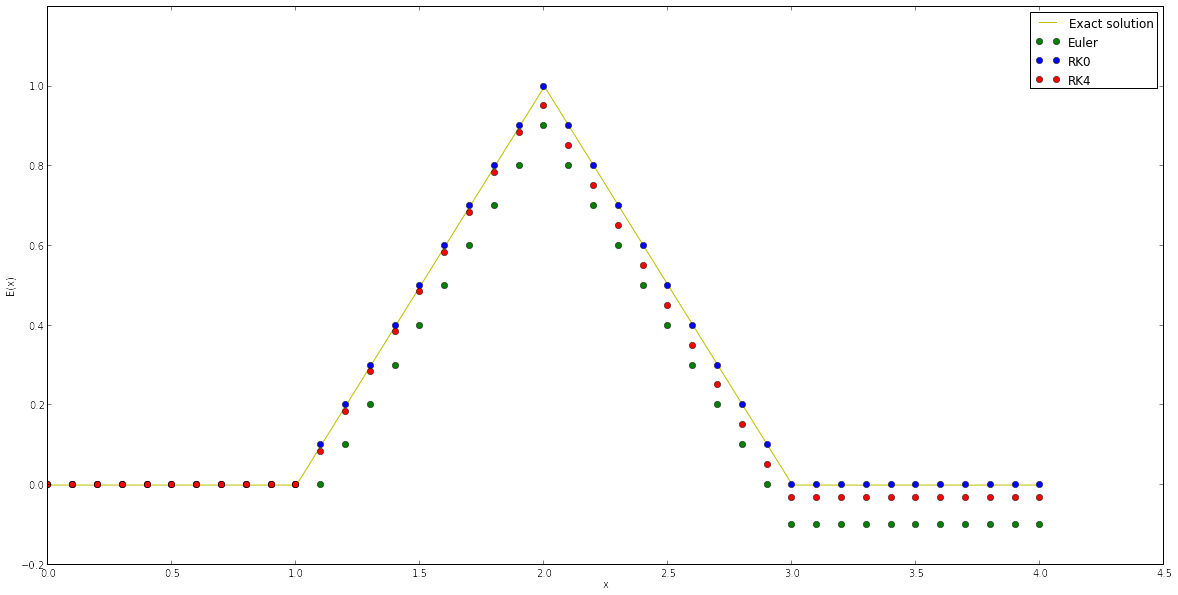

In [194]:
results_euler, results_rk0, results_rk, results_exact = main('electric_field',40,.1)
#np.save('/home/calum/Documents/NumRep/ode/results_rk.npy',results_rk)
#np.save('/home/s1230368/NumRep/ode/results_rk0.npy',results_rk0)
plt.ylabel('E(x)')
plt.xlabel('x')
plt.ylim(-0.2,1.2)

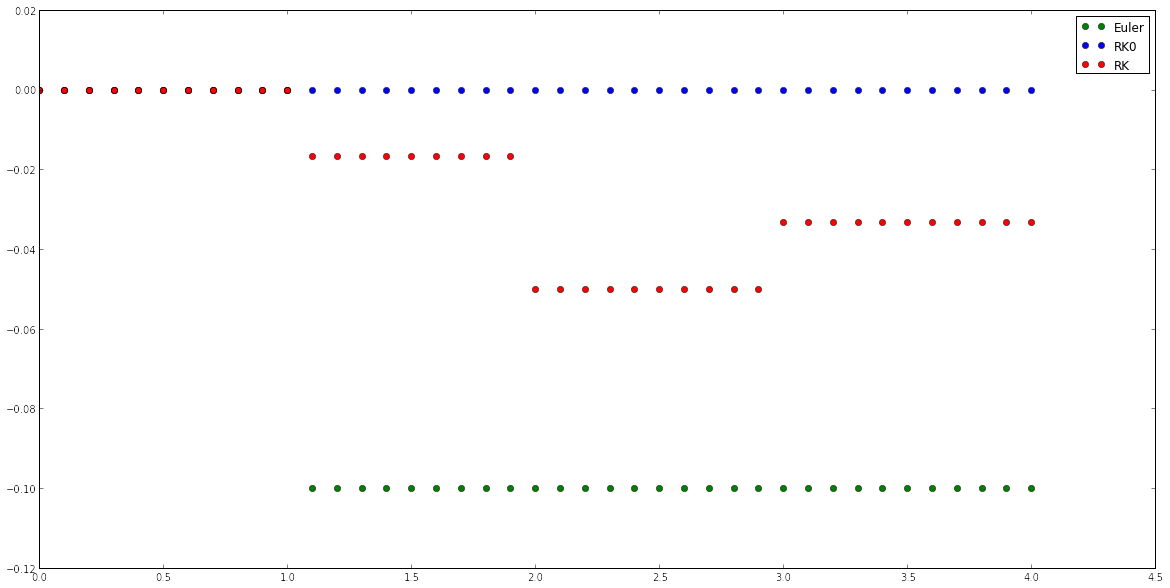

In [189]:
plt.figure(figsize=(20,10))
plt.plot([row[1] for row in results_euler],[row[0] for row in results_euler]-results_exact, 'go',label='Euler')
plt.plot([row[1] for row in results_rk0],[row[0] for row in results_rk0]-results_exact, 'bo',label='RK0')
plt.plot([row[1] for row in results_rk],[row[0] for row in results_rk]-results_exact, 'ro',label='RK')
plt.legend()

('Running ODE integration for', 'voltage', 'with nsteps=', 10, ' and dt=', 0.4)
('Engine has finished with', 'Euler')
('Engine has finished with', 'RK0')
('Engine has finished with', 'RK')


(-1.2, 0.1)

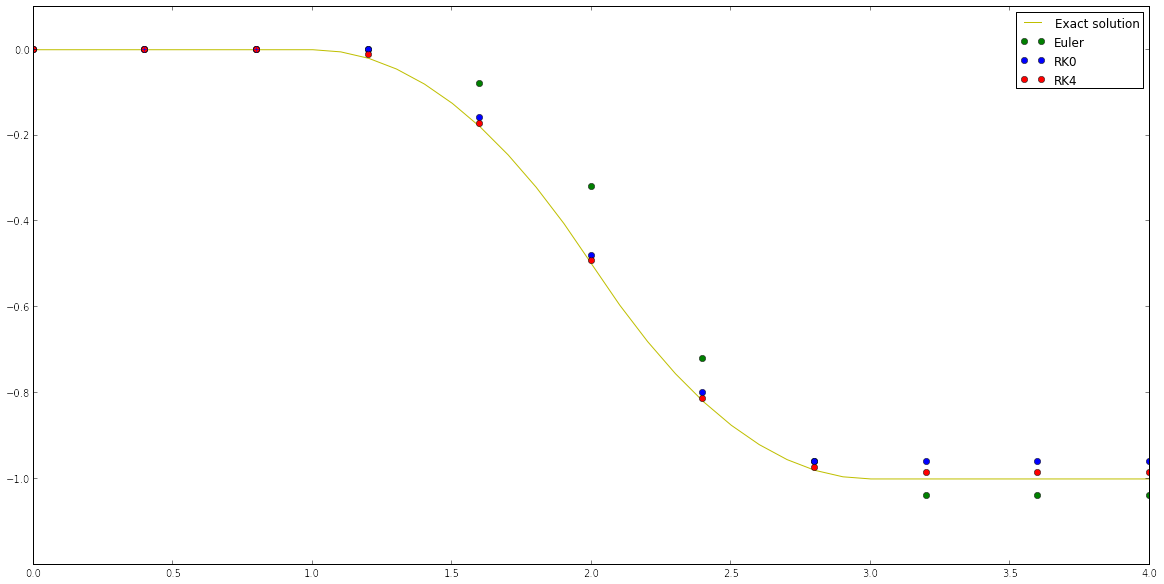

In [192]:
results_euler, results_rk0, results_rk, results_exact = main('voltage',10,0.4,voltage_method='analytic')
plt.plot([row[1] for row in results_rk],[row[0] for row in results_rk0], 'b+',label='RK')
plt.ylim(-1.2,0.1)
#results_euler, results_rk0, results_rk, results_exact = main('voltage',20,0.2,voltage_method='analytic')
#plt.ylim(-1.2,0.1)

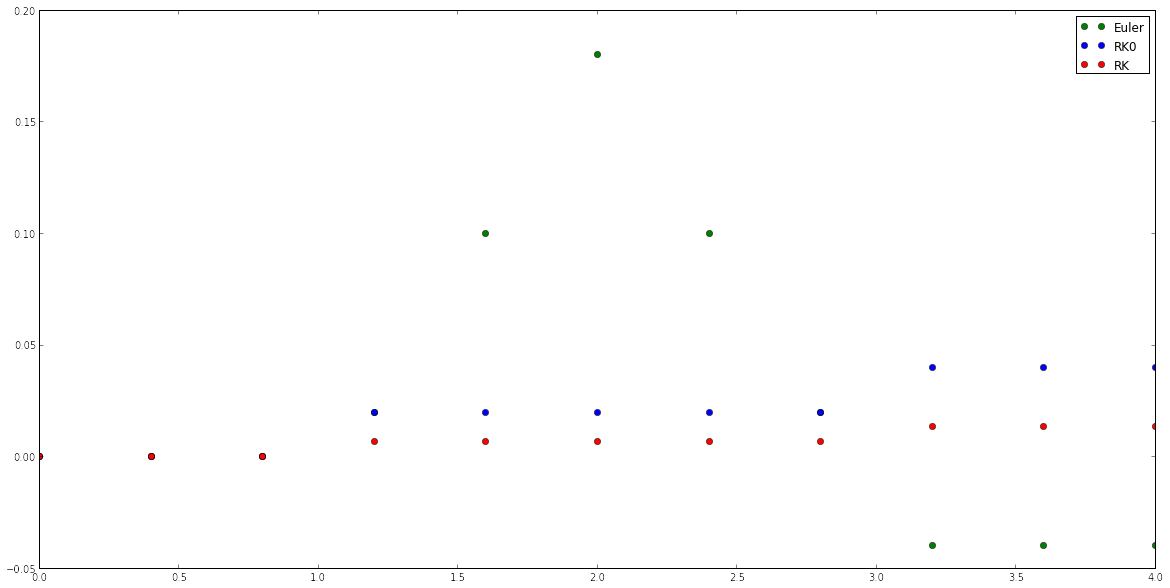

In [152]:
plt.figure(figsize=(20,10))
plt.plot([row[1] for row in results_euler],[row[0] for row in results_euler]-results_exact, 'go',label='Euler')
plt.plot([row[1] for row in results_rk0],[row[0] for row in results_rk0]-results_exact, 'bo',label='RK0')
plt.plot([row[1] for row in results_rk],[row[0] for row in results_rk]-results_exact, 'ro',label='RK')
plt.legend()

Creating ODE: electric field


(-1.2, 1.2)

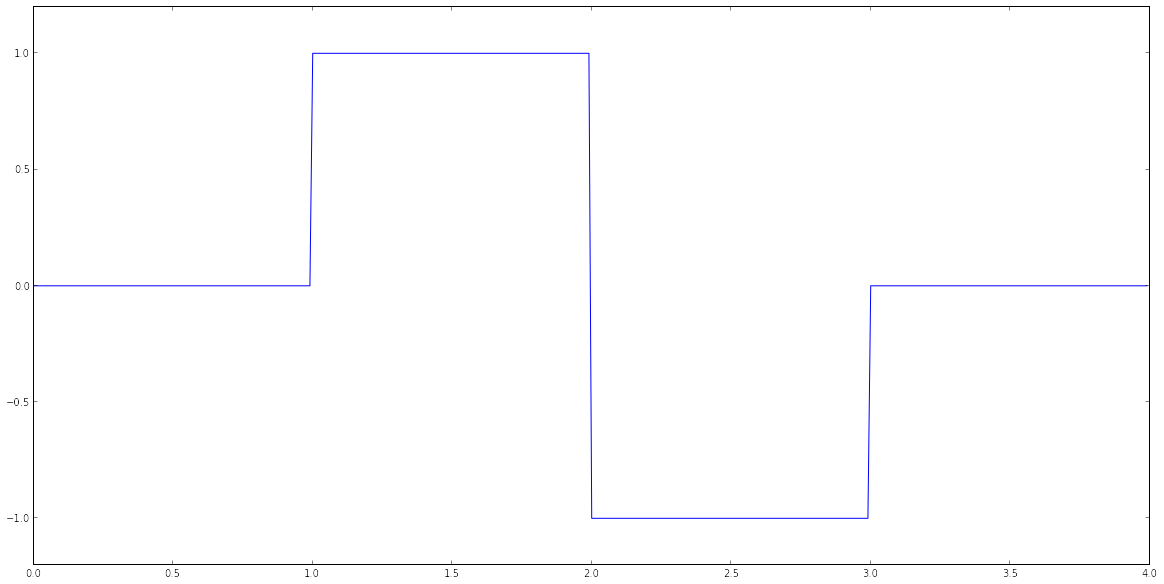

In [96]:
ode = ode_electric_field(1)
plt.figure(figsize=(20,10))
plt.plot([x for x in np.arange(0, 4, 0.01)],[ode.first_derivative([x,x]) for x in np.arange(0,4,0.01)])
plt.ylim(-1.2,1.2)

In [138]:
def find_t(array,t):
    array = np.array([row[1] for row in array])
    return (np.abs(array-t)).argmin()

find_t(results_rk,2.5), results_rk[find_t(results_rk,2.5)]

(25, array([ 0.45,  2.5 ]))

In [131]:
results_rk[5]

array([ 0. ,  0.5])

In [79]:
step_rk()

<__main__.step_rk instance at 0x95483f8>

In [163]:
[t for t in np.arange(0,4,0.1)]

[0.0,
 0.10000000000000001,
 0.20000000000000001,
 0.30000000000000004,
 0.40000000000000002,
 0.5,
 0.60000000000000009,
 0.70000000000000007,
 0.80000000000000004,
 0.90000000000000002,
 1.0,
 1.1000000000000001,
 1.2000000000000002,
 1.3,
 1.4000000000000001,
 1.5,
 1.6000000000000001,
 1.7000000000000002,
 1.8,
 1.9000000000000001,
 2.0,
 2.1000000000000001,
 2.2000000000000002,
 2.3000000000000003,
 2.4000000000000004,
 2.5,
 2.6000000000000001,
 2.7000000000000002,
 2.8000000000000003,
 2.9000000000000004,
 3.0,
 3.1000000000000001,
 3.2000000000000002,
 3.3000000000000003,
 3.4000000000000004,
 3.5,
 3.6000000000000001,
 3.7000000000000002,
 3.8000000000000003,
 3.9000000000000004]